<h1>Reinforcement Learning Final Project - Stock Trading Algorithm</h1>
    
<br>
Implementation using the 
"anytrading" environment in OpenAIGym
<br>
https://github.com/AminHP/gym-anytrading

In [1]:
pip install gym-anytrading

Note: you may need to restart the kernel to use updated packages.


In [2]:
# importing the OpenAIGym Environment for stock trading
import gym
import gym_anytrading
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from gym_anytrading.datasets import STOCKS_GOOGL
import random


In [3]:
# Google Stock dataset
STOCKS_GOOGL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-22,198.528534,199.524521,196.196198,196.946945,196.946945,3433700
2009-05-26,196.171173,202.702698,195.195190,202.382385,202.382385,6202700
2009-05-27,203.023026,206.136139,202.607605,202.982986,202.982986,6062500
2009-05-28,204.544540,206.016022,202.507507,205.405411,205.405411,5332200
2009-05-29,206.261261,208.823822,205.555557,208.823822,208.823822,5291100
...,...,...,...,...,...,...
2018-08-23,1219.880005,1235.170044,1219.349976,1221.160034,1221.160034,1233300
2018-08-24,1226.000000,1237.400024,1221.420044,1236.750000,1236.750000,1222700
2018-08-27,1244.140015,1257.869995,1240.680054,1256.270020,1256.270020,1429000


In [4]:
env = gym.make('stocks-v0')
env_1 = gym.make('stocks-v0',
               df = STOCKS_GOOGL,
               window_size = 1,
               frame_bound = (1000, 1500))

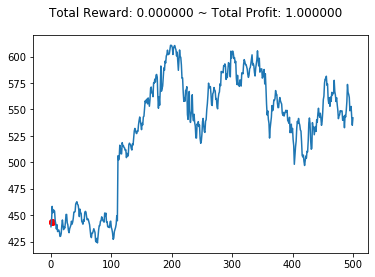

In [5]:
env_1.reset()
env_1.render()

Max_possible_profit signifies that if the market didn't have trade fees, you could have earned 12.468122338293616 units of currency by starting with 1.0. In other words, your money increased over 1200%.

In [6]:
env_1.max_possible_profit()

12.468122338293616

In [8]:
print(env_1.action_space)
# 0 for sell and 1 for buying

Discrete(2)


In [9]:
action = 1
print(env_1.step(action))

(array([[443.993988,   4.789795]]), 0, False, {'total_reward': 0.0, 'total_profit': 1.0, 'position': 1})


In [10]:
observation, reward, done, info = env_1.step(action)

<h2>Random and Heuristic Methods:</h2>

<h3>Method 1: Random Buy/Sell</h3>

[[439.204193   0.      ]]
info:  {'total_reward': 43.881562999999005, 'total_profit': 0.16980822786253566, 'position': 1}


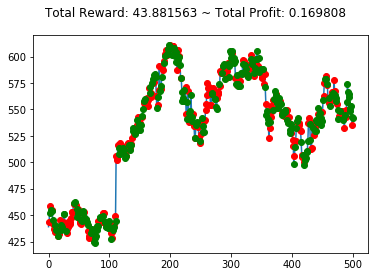

In [11]:
state = env_1.reset()
print(state)
while True:
    action = env_1.action_space.sample()
    state, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()

<h3>Method 2: Buy low sell high (last ten days moving average)</h3>

info:  {'total_reward': 75.97241000000008, 'total_profit': 0.5742683958334958, 'position': 1}


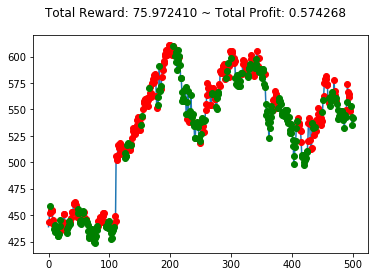

In [12]:
observation = env_1.reset()

last_ten_days = [] # moving average
moving_avg = 0
while True:
    if len(last_ten_days) < 10:
        last_ten_days.append(observation[0][0])
    else:
        last_ten_days.pop(0)
        last_ten_days.append(observation[0][0])
    moving_avg = sum(last_ten_days) / len(last_ten_days)
    
    
    if observation[0][0] < moving_avg:
        action = 1 # buy)
    elif observation[0][0] > moving_avg:
        action = 0 # sell
    
    observation, reward, done, info = env_1.step(action)

    if done:
        print("info: ", info)
        break

env_1.render_all()
    

<h3>Method 3: Buy and Hold Strategy</h3>
<br>
Buy the stock at the beginning and hold throughout the period and sell stock at the very end.

info:  {'total_reward': 94.43661499999996, 'total_profit': 1.1879821448544323, 'position': 0}


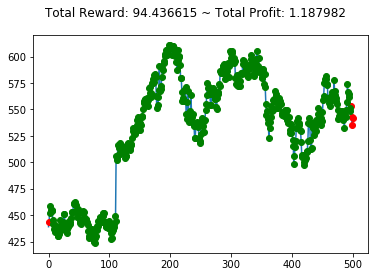

In [13]:
state = env_1.reset()
count = 0
while True:
    count += 1
    action = 1
    if count > 495:
        action = 0
    state, reward, done, info = env_1.step(action)
    
    if done:
        print("info: ", info)
        break

env_1.render_all()

<h2>Reinforcement Learning Methods:</h2>

<h3>Method 4: Deep Q-Learning (DQN)</h3>

In [14]:
# Parameters
gamma = 0.99
actsize = env_1.action_space.n
obssize = env_1.observation_space.low.size

In [15]:
def model_creator():
    model = keras.Sequential()
    model.add(layers.Dense(32,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(128,activation="relu"))
    model.add(layers.Dense(actsize,activation="linear"))
    return model

In [16]:
batch_size = 10
# Model used for selecting actions (principal)
model = model_creator()
# Then create the target model. This will periodically be copied from the principal network 
model_target = model_creator()

model.build((batch_size,obssize,))
model_target.build((batch_size,obssize,))

**Training the Model:**

In [17]:
# environment for training
env_training = gym.make('stocks-v0', df = STOCKS_GOOGL, window_size = 1, frame_bound = (1, 1000))

In [18]:
tf.keras.backend.set_floatx('float64')

In [44]:
def train(model, env, epsilon, adpative):
    optimizer = keras.optimizers.Adam(learning_rate=0.0005)


    # Our Experience Replay memory 
    action_history = []
    state_history = []
    state_next_history = []
    rewards_history = []
    done_history = []
    running_rewards_history = []

    # Replay memory size
    max_memory = 100 # You can experiment with different sizes.

    running_reward = 0
    timestep_count = 0

    update_after_actions = 4

    # How often to update the target network
    target_update_every = 50
    loss_function = keras.losses.MeanSquaredError()

#     epsilon = 1
#     adpative = True

    state = env_training.reset()[0]
    while True:
        timestep_count += 1

        # adpative epsilon decay
        if adpative:
            epsilon = np.exp(-1e-2 * timestep_count)

        # exploration
        rand = np.random.uniform(0, 1)
        if rand < epsilon:
            # Take random action
            action = np.random.choice(actsize)
        else:
            # Predict action Q-values
            # From environment state
            state_t = tf.convert_to_tensor(state)
            state_t = tf.expand_dims(state_t, 0)
            action_vals = model(state_t, training=False)
            # Choose the best action
            action = int(tf.keras.backend.argmax(action_vals))

        state_next, reward, done, info = env_training.step(action)
        state_next = state_next[0]


        # Save action/states and other information in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        rewards_history.append(reward)
        done_history.append(done)
        running_rewards_history.append(info['total_reward'])

        running_reward = info['total_reward']

        state = state_next

        # Update every Xth frame to speed up (optional)
        # and if you have sufficient history
        if timestep_count % update_after_actions == 0 and len(action_history) > batch_size:
            # Sample a set of batch_size memories from the history
            rand_samples = np.random.randint(0, len(action_history), batch_size)

            action_sample = np.array(action_history)[rand_samples]
            state_sample = np.array(state_history)[rand_samples]
            state_next_sample = np.array(state_next_history)[rand_samples]
            rewards_sample = np.array(rewards_history)[rand_samples]
            done_sample = np.array(done_history)[rand_samples]

            # Create for the sample states the targets (r+gamma * max Q(...)
            state_next_sample_t = tf.convert_to_tensor(state_next_sample)
            Q_next_state = np.max(model_target.predict(state_next_sample_t), axis=1)   
            Q_targets = rewards_sample + gamma * Q_next_state

            # What actions are relevant and need updating
            relevant_actions = tf.one_hot(action_sample, actsize)

            # we will use Gradient tape to do a custom gradient 
            # in the `with` environment we will record a set of operations
            # and then we will take gradients with respect to the trainable parameters
            # in the neural network
            with tf.GradientTape() as tape:
                # Train the model on your action selecting network
                q_values = model(state_sample) 
                # We consider only the relevant actions
                Q_of_actions = tf.reduce_sum(tf.multiply(q_values, relevant_actions), axis=1)
                # Calculate loss between principal network and target network
                loss = loss_function(Q_targets, Q_of_actions)

                # Nudge the weights of the trainable variables towards 
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if timestep_count % target_update_every == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, total profit: {} epsilon {}"
            print(template.format(running_reward, timestep_count, info["total_profit"], epsilon))

        # Don't let the memory grow beyond the limit
        if len(rewards_history) > max_memory:
            del action_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del rewards_history[:1]
            del done_history[:1]

        if done:
            print("info: ", info)
            break

    env_training.render_all()
    
    return running_rewards_history

running reward: 13.42 at episode 50, total profit: 0.9184080947422828 epsilon 0.6065306597126334
running reward: 37.18 at episode 100, total profit: 0.8586465936554906 epsilon 0.36787944117144233
running reward: 38.56 at episode 150, total profit: 0.7999089522079685 epsilon 0.22313016014842982
running reward: 10.98 at episode 200, total profit: 0.6634820279658437 epsilon 0.1353352832366127
running reward: -30.07 at episode 250, total profit: 0.5338319944958754 epsilon 0.0820849986238988
running reward: -27.65 at episode 300, total profit: 0.531032327271304 epsilon 0.049787068367863944
running reward: -16.54 at episode 350, total profit: 0.5323041298657895 epsilon 0.0301973834223185
running reward: 47.65 at episode 400, total profit: 0.6345539557194348 epsilon 0.01831563888873418
running reward: 50.26 at episode 450, total profit: 0.6211201303946692 epsilon 0.011108996538242306
running reward: 25.26 at episode 500, total profit: 0.5618323476428763 epsilon 0.006737946999085467
running re

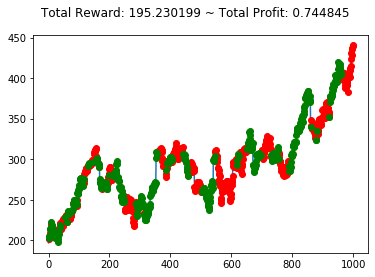

In [46]:
# train on Google stock data from timestep 1 to 1000
running_rewards_history = train(model, env_training, 1, True)


In [47]:
model.save("trained_model")

INFO:tensorflow:Assets written to: trained_model/assets


Text(0, 0.5, 'Running Reward')

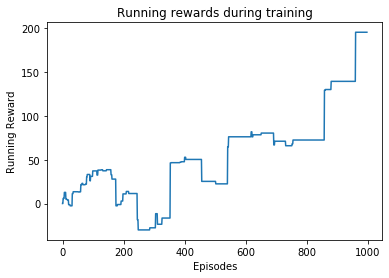

In [49]:
# plot the running rewards
plt.plot(running_rewards_history)
plt.title("Running rewards during training")
plt.xlabel("Episodes")
plt.ylabel("Running Reward")

running reward: 3.49 at episode 50, total profit: 0.9580035043087342 epsilon 0
running reward: 25.36 at episode 100, total profit: 1.040874080210763 epsilon 0
running reward: 57.13 at episode 150, total profit: 1.1494954975304446 epsilon 0
running reward: 57.13 at episode 200, total profit: 1.1494954975304446 epsilon 0
running reward: 73.99 at episode 250, total profit: 1.203879295540389 epsilon 0
running reward: 66.06 at episode 300, total profit: 1.1154306572695003 epsilon 0
running reward: 66.06 at episode 350, total profit: 1.1154306572695003 epsilon 0
running reward: 152.81 at episode 400, total profit: 1.453935867626678 epsilon 0
running reward: 164.05 at episode 450, total profit: 1.4863799093117591 epsilon 0
running reward: 164.05 at episode 500, total profit: 1.4863799093117591 epsilon 0
running reward: 125.12 at episode 550, total profit: 1.2671597062315227 epsilon 0
running reward: 131.69 at episode 600, total profit: 1.2780449438473003 epsilon 0
running reward: 161.53 at ep

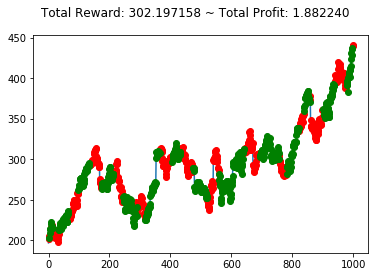

In [52]:
# test model results on the next leg of the stock data from time 1000 to 1500
_ = train(model, env_1, 0, False)

*The reward of the Deep Q Learning function after training for 1000 timesteps is: 186.441452 and the total profit is 1.5480215108859194. The initial money increased by 155%.*